## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

# На нашем курсе по аналитике https://karpov.courses/ секцию про bootstrap читают ребята из https://www.experiment-fest.ru/
# Функция get_bootstrap взята из их занятия по АБ тестам

In [4]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [5]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [6]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.00101, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

100%|██████████| 1000/1000 [00:00<00:00, 2263.82it/s]


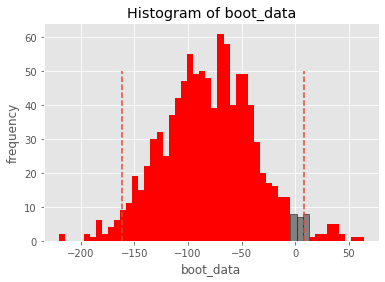

In [9]:
booted_data = get_bootstrap(df.sample_1, df.sample_2) # в результате хранится разница двух распределений, ДИ и pvalue

In [10]:
booted_data["p_value"] # альфа

0.06411659388911388

In [11]:
booted_data["quants"] # ДИ

,0
0.025,-161.222792
0.975,7.717691


In [12]:
data_ab = pd.read_csv('hw_bootstrap.csv', sep=';', decimal=',')

In [13]:
data_ab.head()

,Unnamed: 0,value,experimentVariant
0,1,9.773113,Treatment
1,2,9.311246,Treatment
2,3,11.172828,Treatment
3,4,11.624510,Treatment
4,5,10.462331,Treatment


In [14]:
data_ab.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [15]:
data_ab.groupby('experimentVariant').agg({'value': 'count'})

,value
experimentVariant,
Control,500
Treatment,50


In [16]:
data_ab.groupby('experimentVariant').agg({'value': 'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,10.367236


In [17]:
data_ab.groupby('experimentVariant').agg({'value': 'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.420193


<AxesSubplot:xlabel='experimentVariant', ylabel='value'>

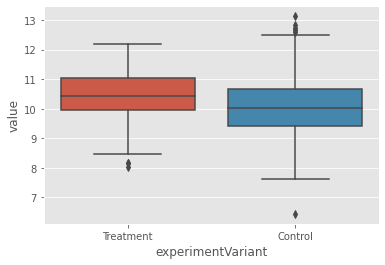

In [18]:
sns.boxplot(x="experimentVariant", y="value", data=data_ab)

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value'>

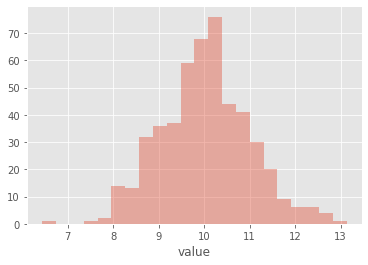

In [19]:
sns.distplot(data_ab[data_ab.experimentVariant == 'Control'].value, kde=False)

<AxesSubplot:xlabel='value'>

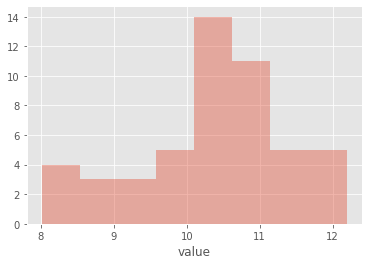

In [20]:
sns.distplot(data_ab[data_ab.experimentVariant == 'Treatment'].value, kde=False)

In [21]:
mannwhitneyu(data_ab[data_ab.experimentVariant == 'Treatment'].value, 
             data_ab[data_ab.experimentVariant == 'Control'].value)

MannwhitneyuResult(statistic=9508.0, pvalue=0.0026182097937983984)

In [22]:
ttest_ind(data_ab[data_ab.experimentVariant == 'Treatment'].value, 
             data_ab[data_ab.experimentVariant == 'Control'].value)

Ttest_indResult(statistic=2.331858965573001, pvalue=0.020069539127355422)

100%|██████████| 1000/1000 [00:00<00:00, 2067.39it/s]


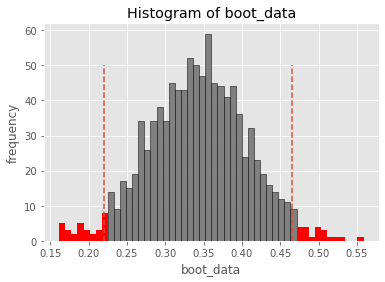

{'boot_data': [0.285458528586249,
  0.3826748569862303,
  0.43755625058250097,
  0.28656621822863504,
  0.2925445516189052,
  0.2932311688607561,
  0.36085644779358467,
  0.3116146402026303,
  0.36235433530758077,
  0.4491734091170423,
  0.23657788209401256,
  0.3413643568705509,
  0.34041121683602116,
  0.49379615229398666,
  0.4102056431375778,
  0.36890054881280077,
  0.3208531302781249,
  0.5063205729363874,
  0.35572400531743487,
  0.2958033271132241,
  0.28931327810427887,
  0.3015572173493199,
  0.3349871036519574,
  0.3611794006826615,
  0.4045055140543949,
  0.3132983341301745,
  0.3998597936375933,
  0.3389166743339516,
  0.3331656109553459,
  0.3008851931673964,
  0.3133981429373121,
  0.4178732489871395,
  0.2968915421574369,
  0.2648220451059508,
  0.41309386246801943,
  0.3887151491195026,
  0.2744203711067418,
  0.3766143291789888,
  0.37783381828211426,
  0.29096965765889454,
  0.39719857693900323,
  0.2829991279486507,
  0.42853506156506427,
  0.2646741390929989,
  0.2

In [23]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data_ab[data_ab.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

100%|██████████| 1000/1000 [00:00<00:00, 1796.44it/s]


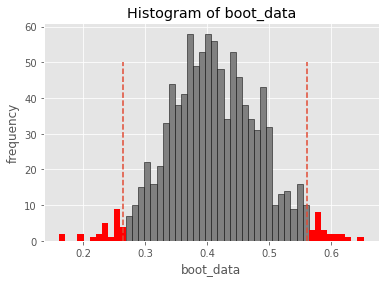

{'boot_data': [0.4322881194518251,
  0.46256626516223065,
  0.4154644289825855,
  0.428355603832701,
  0.45715077520066494,
  0.41639514429511504,
  0.39193917575794934,
  0.25379070635684986,
  0.3675406997779005,
  0.49697251219919547,
  0.4531881542366998,
  0.47860761859819956,
  0.3731251936479447,
  0.42954021464113534,
  0.5474582547490998,
  0.48021439080233463,
  0.39281390641788505,
  0.3951452243920004,
  0.4554880173024447,
  0.3847446476517886,
  0.3307314047234504,
  0.41230479045029966,
  0.5115479586097145,
  0.22719470329704983,
  0.394582423648,
  0.39545272076784954,
  0.45907257923232514,
  0.5383772609793702,
  0.46278987655674,
  0.4331696366446858,
  0.44833698397623145,
  0.41445565241595084,
  0.39777675825495074,
  0.4419673327125091,
  0.31215740243595125,
  0.49573144592969953,
  0.417151195391785,
  0.3600701612412749,
  0.25730060461559034,
  0.4107078010499512,
  0.36932564972939996,
  0.4092828212182207,
  0.4002744549004049,
  0.4374830629843691,
  0.31

In [24]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data_ab[data_ab.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [25]:
5.4687657931866705e-08 < 0.0000002

True

In [ ]:
ads_data = pd.read_csv('ads_data.csv.zip')

In [34]:
ads_data.groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time': 'count'}) \
    .pivot(index='ad_id', columns='event', values='time') \
    .reset_index()

event,ad_id,click,view
0,3,9.0,490.0
1,2132,1.0,95.0
2,2276,2.0,1454.0
3,2475,NaN,132.0
4,2643,3.0,286.0
...,...,...,...
350,121941,1.0,640.0
351,121943,15.0,1722.0
352,122042,1.0,155.0
353,122063,1.0,260.0
